# Simulation of Risk Factors

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import scipy 
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from IPython.display import display, Image

np.random.seed(123) # Set the seed for NumPy's random number generator to ensure reproducibility
tf.random.set_seed(123) # Set the seed for TensorFlow's random number generator to ensure reproducibility

mpl.rcParams['font.family'] = 'serif' # Set the default font family to 'serif' in Matplotlib
mpl.rcParams['font.serif'] = ['Times New Roman'] # Set the specific serif font to 'Times New Roman' in Matplotlib
plt.rcParams.update({'font.size': 14}) # Update the font size for all text elements in Matplotlib to 14

regen_plots = False # Flag indicating whether to regenerate plots

## Preparation of parameters of the distributions

In [2]:
# Number of samples to generate
num_samples = 50000

# Number of variables/features
N = 10

# Degrees of freedom for chi-square distribution
df_X = 10

# Generate an array of means for the variables, uniformly distributed between 0.1 and 3
mean_X = np.random.uniform(low=0.1, high=3, size=N)

# Generate an array of standard deviations for the variables, uniformly distributed between 0.01 and 0.8
std_devs = np.random.uniform(low=0.01, high=0.8, size=N)

# Generate a random correlation matrix with values uniformly distributed between 0.5 and 1
correlation_matrix = np.random.uniform(low=0.5, high=1, size=(N, N))

# Make the correlation matrix symmetric
correlation_matrix = (correlation_matrix + correlation_matrix.T) / 2

# Compute the eigenvalues and eigenvectors of the correlation matrix
eigvals, eigvecs = np.linalg.eigh(correlation_matrix)

# Ensure all eigenvalues are non-negative (enforce positive semi-definiteness)
eigvals[eigvals < 0] = 0 

# Reconstruct the correlation matrix from the eigenvalues and eigenvectors
correlation_matrix = eigvecs @ np.diag(eigvals) @ eigvecs.T

# Set the diagonal elements of the correlation matrix to 1 (variance of 1 for standardized variables)
np.fill_diagonal(correlation_matrix, 1)

# Compute the covariance matrix from the standard deviations and correlation matrix
cov_X = np.dot(np.dot(np.diag(std_devs), correlation_matrix), np.diag(std_devs))

# Round the mean, standard deviations, correlation matrix, and covariance matrix for better readability
mean_X = np.round(mean_X, 3)
std_devs = np.round(std_devs, 3)
correlation_matrix = np.round(correlation_matrix, 3)
cov_X = np.round(cov_X, 3)

In [3]:
# Display and save the correlation matrix
correlation_matrix_out = pd.DataFrame(correlation_matrix)
correlation_matrix_out.columns = correlation_matrix_out.columns + 1
correlation_matrix_out.index = correlation_matrix_out.index + 1
correlation_matrix_out.to_csv('out/correlation_matrix_out.csv', index=True)
correlation_matrix_out

1      2      3      4      5      6      7      8      9      10
1   1.000  0.725  0.789  0.716  0.839  0.610  0.699  0.738  0.682  0.717
2   0.725  1.000  0.736  0.831  0.723  0.771  0.741  0.834  0.859  0.724
3   0.789  0.736  1.000  0.740  0.836  0.673  0.731  0.746  0.654  0.723
4   0.716  0.831  0.740  1.000  0.736  0.758  0.714  0.822  0.734  0.809
5   0.839  0.723  0.836  0.736  1.000  0.605  0.819  0.706  0.663  0.726
6   0.610  0.771  0.673  0.758  0.605  1.000  0.758  0.702  0.728  0.802
7   0.699  0.741  0.731  0.714  0.819  0.758  1.000  0.639  0.752  0.739
8   0.738  0.834  0.746  0.822  0.706  0.702  0.639  1.000  0.723  0.720
9   0.682  0.859  0.654  0.734  0.663  0.728  0.752  0.723  1.000  0.604
10  0.717  0.724  0.723  0.809  0.726  0.802  0.739  0.720  0.604  1.000

In [4]:
# Display and save the distribution parameters
params_res_out = pd.DataFrame({'Mean': mean_X, 'Standard Deviation': std_devs,}).transpose()
params_res_out.columns = params_res_out.columns + 1
params_res_out.to_csv('out/dist_params_out.csv', index=True)
params_res_out

1      2      3      4      5      6      7      8   \
Mean                2.120  0.930  0.758  1.699  2.186  1.327  2.944  2.086   
Standard Deviation  0.281  0.586  0.356  0.057  0.324  0.593  0.154  0.149   

                       9      10  
Mean                1.495  1.237  
Standard Deviation  0.430  0.430

## Normally distributed risk factors

Jointly normally distributed risk factors can be simulated using the following decomposition:
$$\mathbf{X}=A\mathbf{Z}+\mu$$
where $\mathbf{Z} \sim N(0,\mathbf{I})$. $A$ is the lower triangular matrix obtained from the Cholesky decomposition of the covariance matrix, and $\mu$ is the mean vector (Fang, 1990). The decomposition ensures that the simulated data respects the specified positive correlations.

In [5]:
def generate_joint_normal(shape, mean, cov):
    num_samples = shape[0] 
    N = shape[1] 

    mean = tf.constant(mean, dtype=tf.float32)
    cov = tf.constant(cov, dtype=tf.float32)

    A = tf.linalg.cholesky(cov)
    Z = tf.random.normal(shape=(num_samples, N))
    X = tf.matmul(Z, tf.transpose(A)) + mean
    
    return X

In [6]:
X_norm_train = generate_joint_normal([num_samples,N], mean_X, cov_X)
np.save('sim_data/X_norm_train.npy', X_norm_train)
X_norm_test = generate_joint_normal([num_samples,N], mean_X, cov_X)
np.save('sim_data/X_norm_test.npy', X_norm_test)

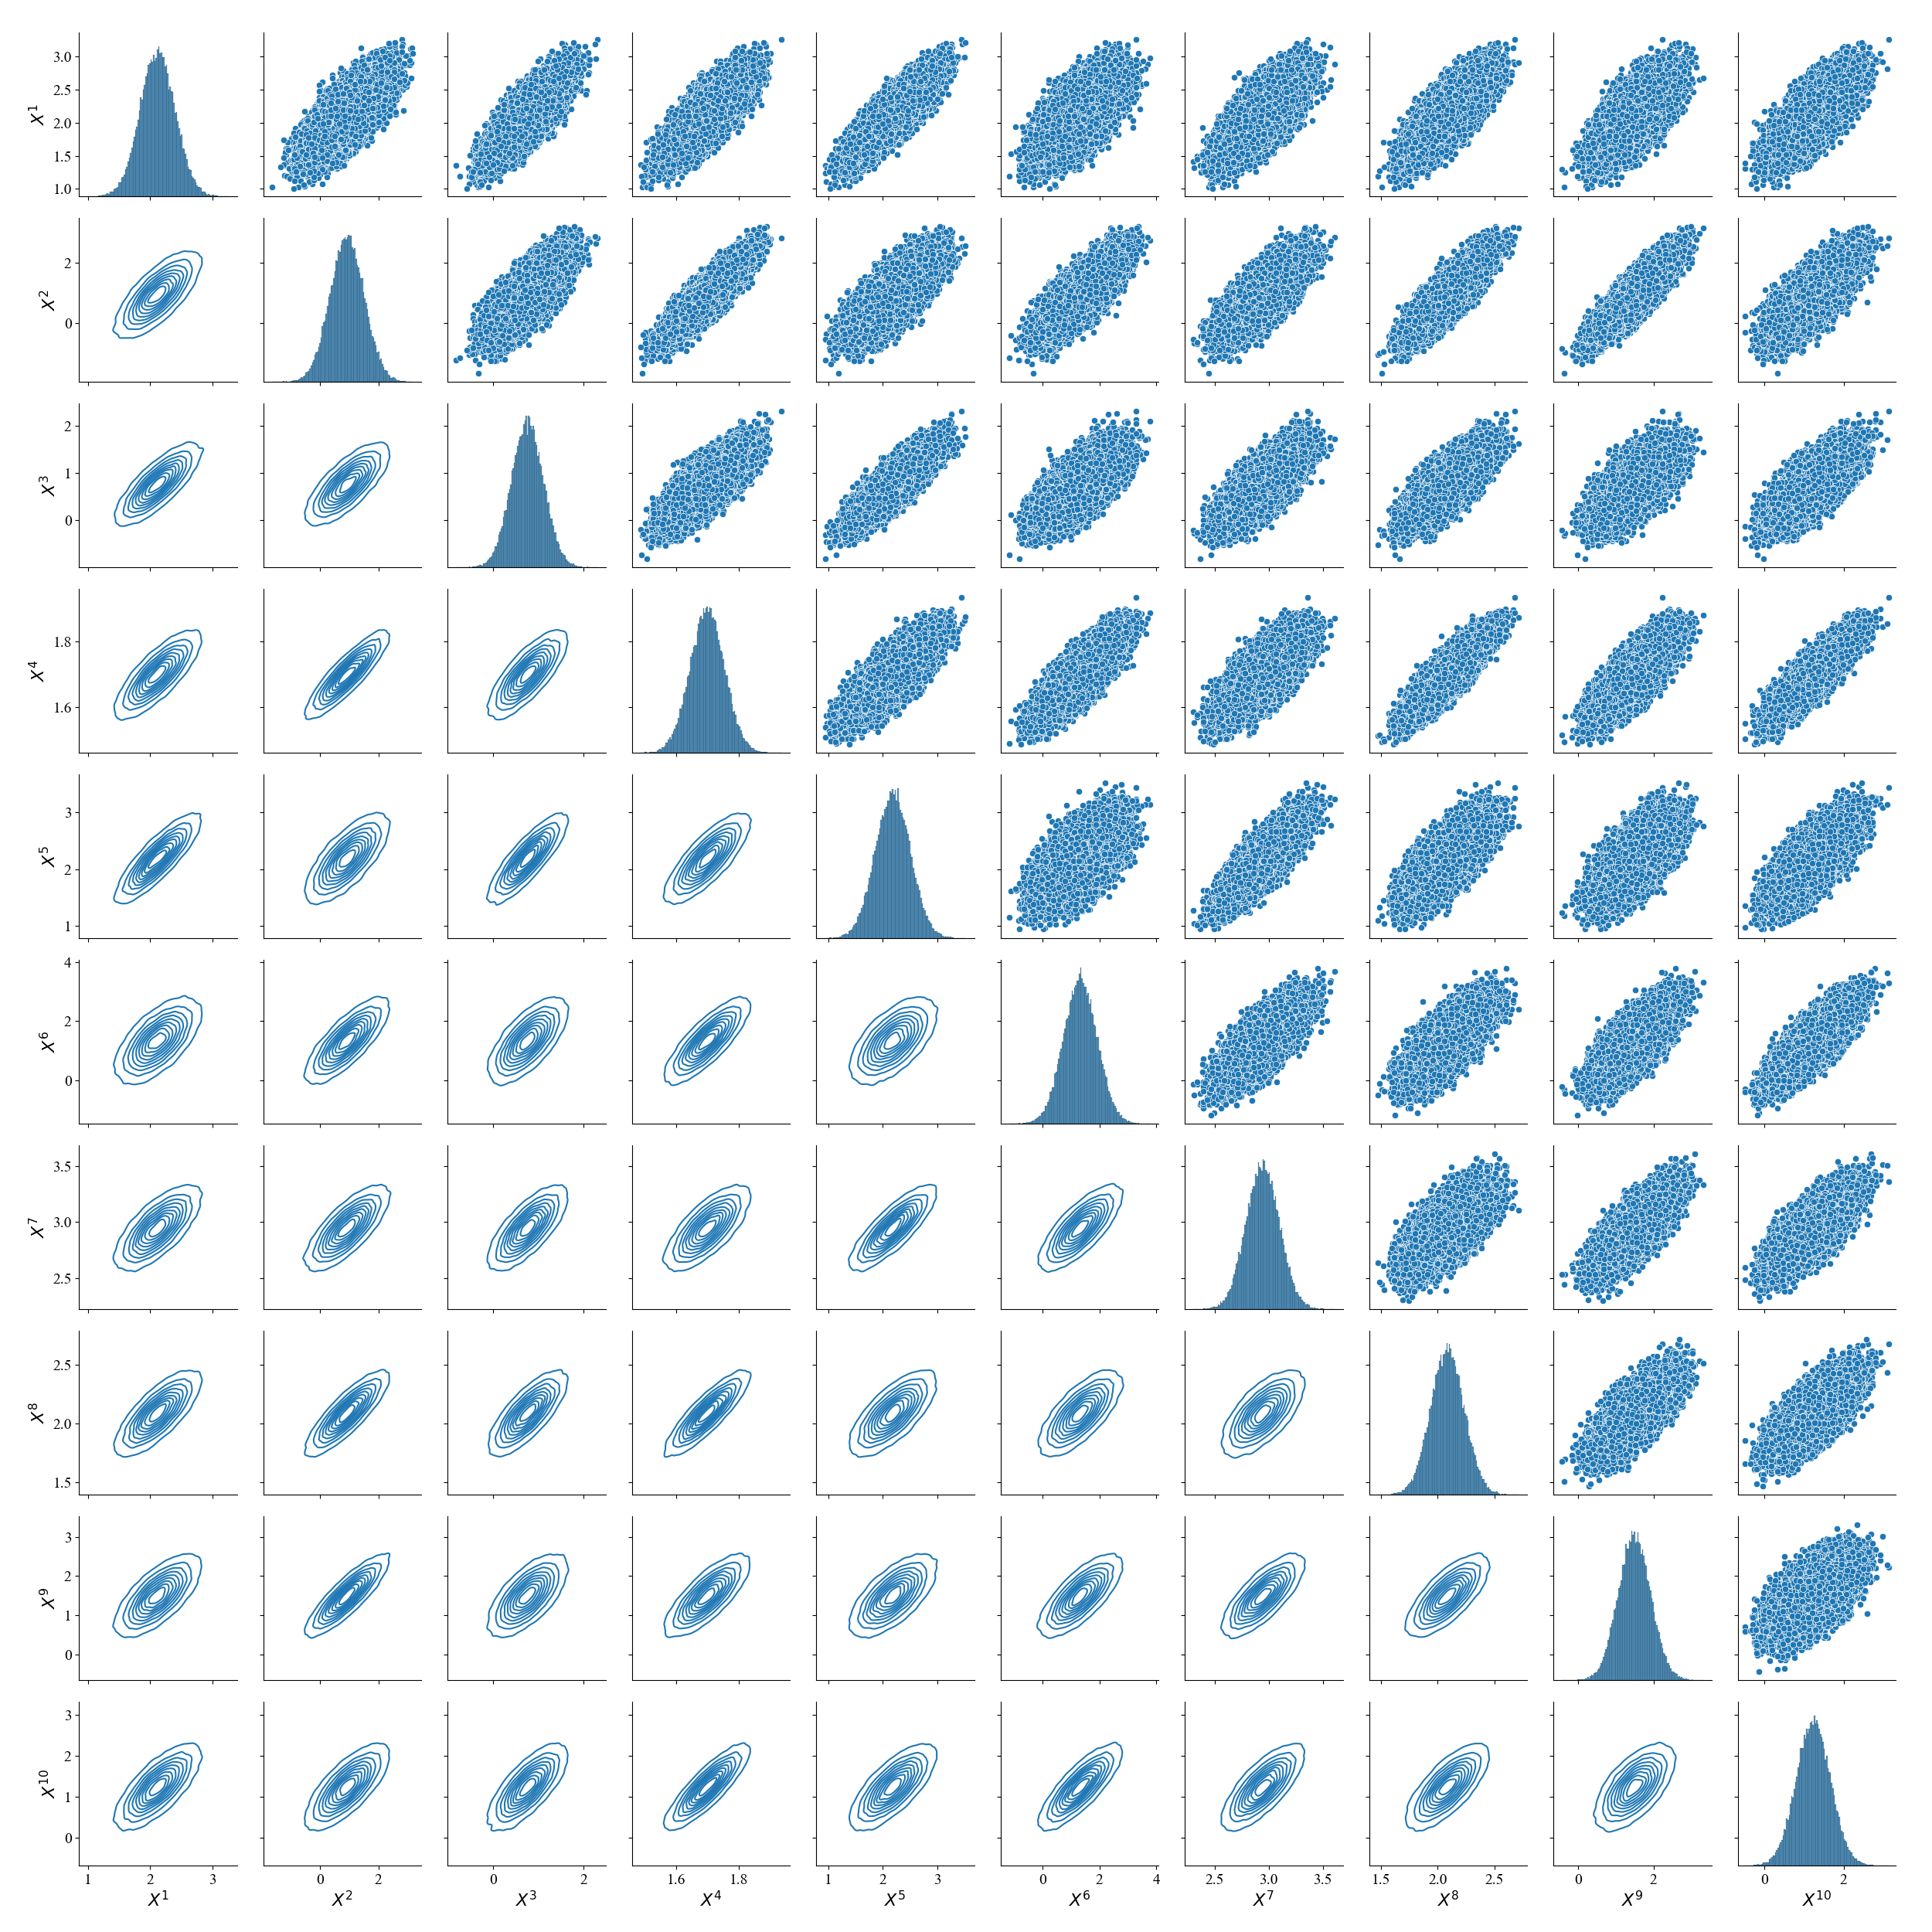

In [7]:
if regen_plots:
    plt.figure(figsize=(15, 10)) 
    g=sns.PairGrid(pd.DataFrame(X_norm_train.numpy()))
    g.map_upper(sns.scatterplot)
    g.map_lower(sns.kdeplot)
    g.map_diag(sns.histplot)

    for i, ax in enumerate(g.axes.flatten()):
        ax.set_xlabel(f'$X^{{{i%10 + 1}}}$', fontsize=16)
        if i % (N + 1) == 0:
            ax.set_xlabel(f'$X^{{{i // (N + 1) + 1}}}$', fontsize=16)
            ax.set_ylabel(f'$X^{{{i // (N + 1) + 1}}}$', fontsize=16)
        elif (i-1) % (N + 1) < N:
            num = int((i-1 % (N + 1) + 1)/10 + 1)
            ax.set_ylabel(f'$X^{{{num}}}$', fontsize=16)

    plt.savefig('fig/X_norm_train.png')
    plt.show()
else:
    display(Image(filename='fig/X_norm_train.png'))

## Student-t distributed risk factors

Jointly Student-t distributed risk factors can be simulated using the following decomposition:
$$\mathbf{T}=\frac{\mathbf{X}}{\sqrt\frac{V}{\nu}}+\mu$$
where $\mathbf{X} \sim N(0,\Sigma)$ and $V \sim \chi^2(\nu)$ with $\nu=5$ being the degrees of freedom. $A$ is the lower triangular matrix obtained from the Cholesky decomposition, $\Sigma=AA'$, and $\mu$ is the mean vector (Genz \& Bretz, 2009).

In [8]:
def generate_joint_t(shape, mean=0, cov=1, df=2):
    num_samples = shape[0]
    N = shape[1]

    mean = tf.constant(mean, dtype=tf.float32)
    cov = tf.constant(cov, dtype=tf.float32)
    
    A = tf.linalg.cholesky(cov)
    Z = tf.random.normal(shape=(num_samples, N))
    X = tf.matmul(Z, tf.transpose(A)) 
    
    CHI_2 = tf.reduce_sum(tf.math.square(tf.random.normal(shape=(num_samples, df))), axis=-1, keepdims=True)
    df = tf.constant(df, dtype=tf.float32)
    
    T = tf.divide(X, tf.sqrt(tf.divide(CHI_2,df))) + mean

    return(T)

In [9]:
X_t_train = generate_joint_t([num_samples,N], mean_X, cov_X, df_X)
np.save('sim_data/X_t_train.npy', X_t_train)
X_t_test = generate_joint_t([num_samples,N], mean_X, cov_X, df_X)
np.save('sim_data/X_t_test.npy', X_t_test)

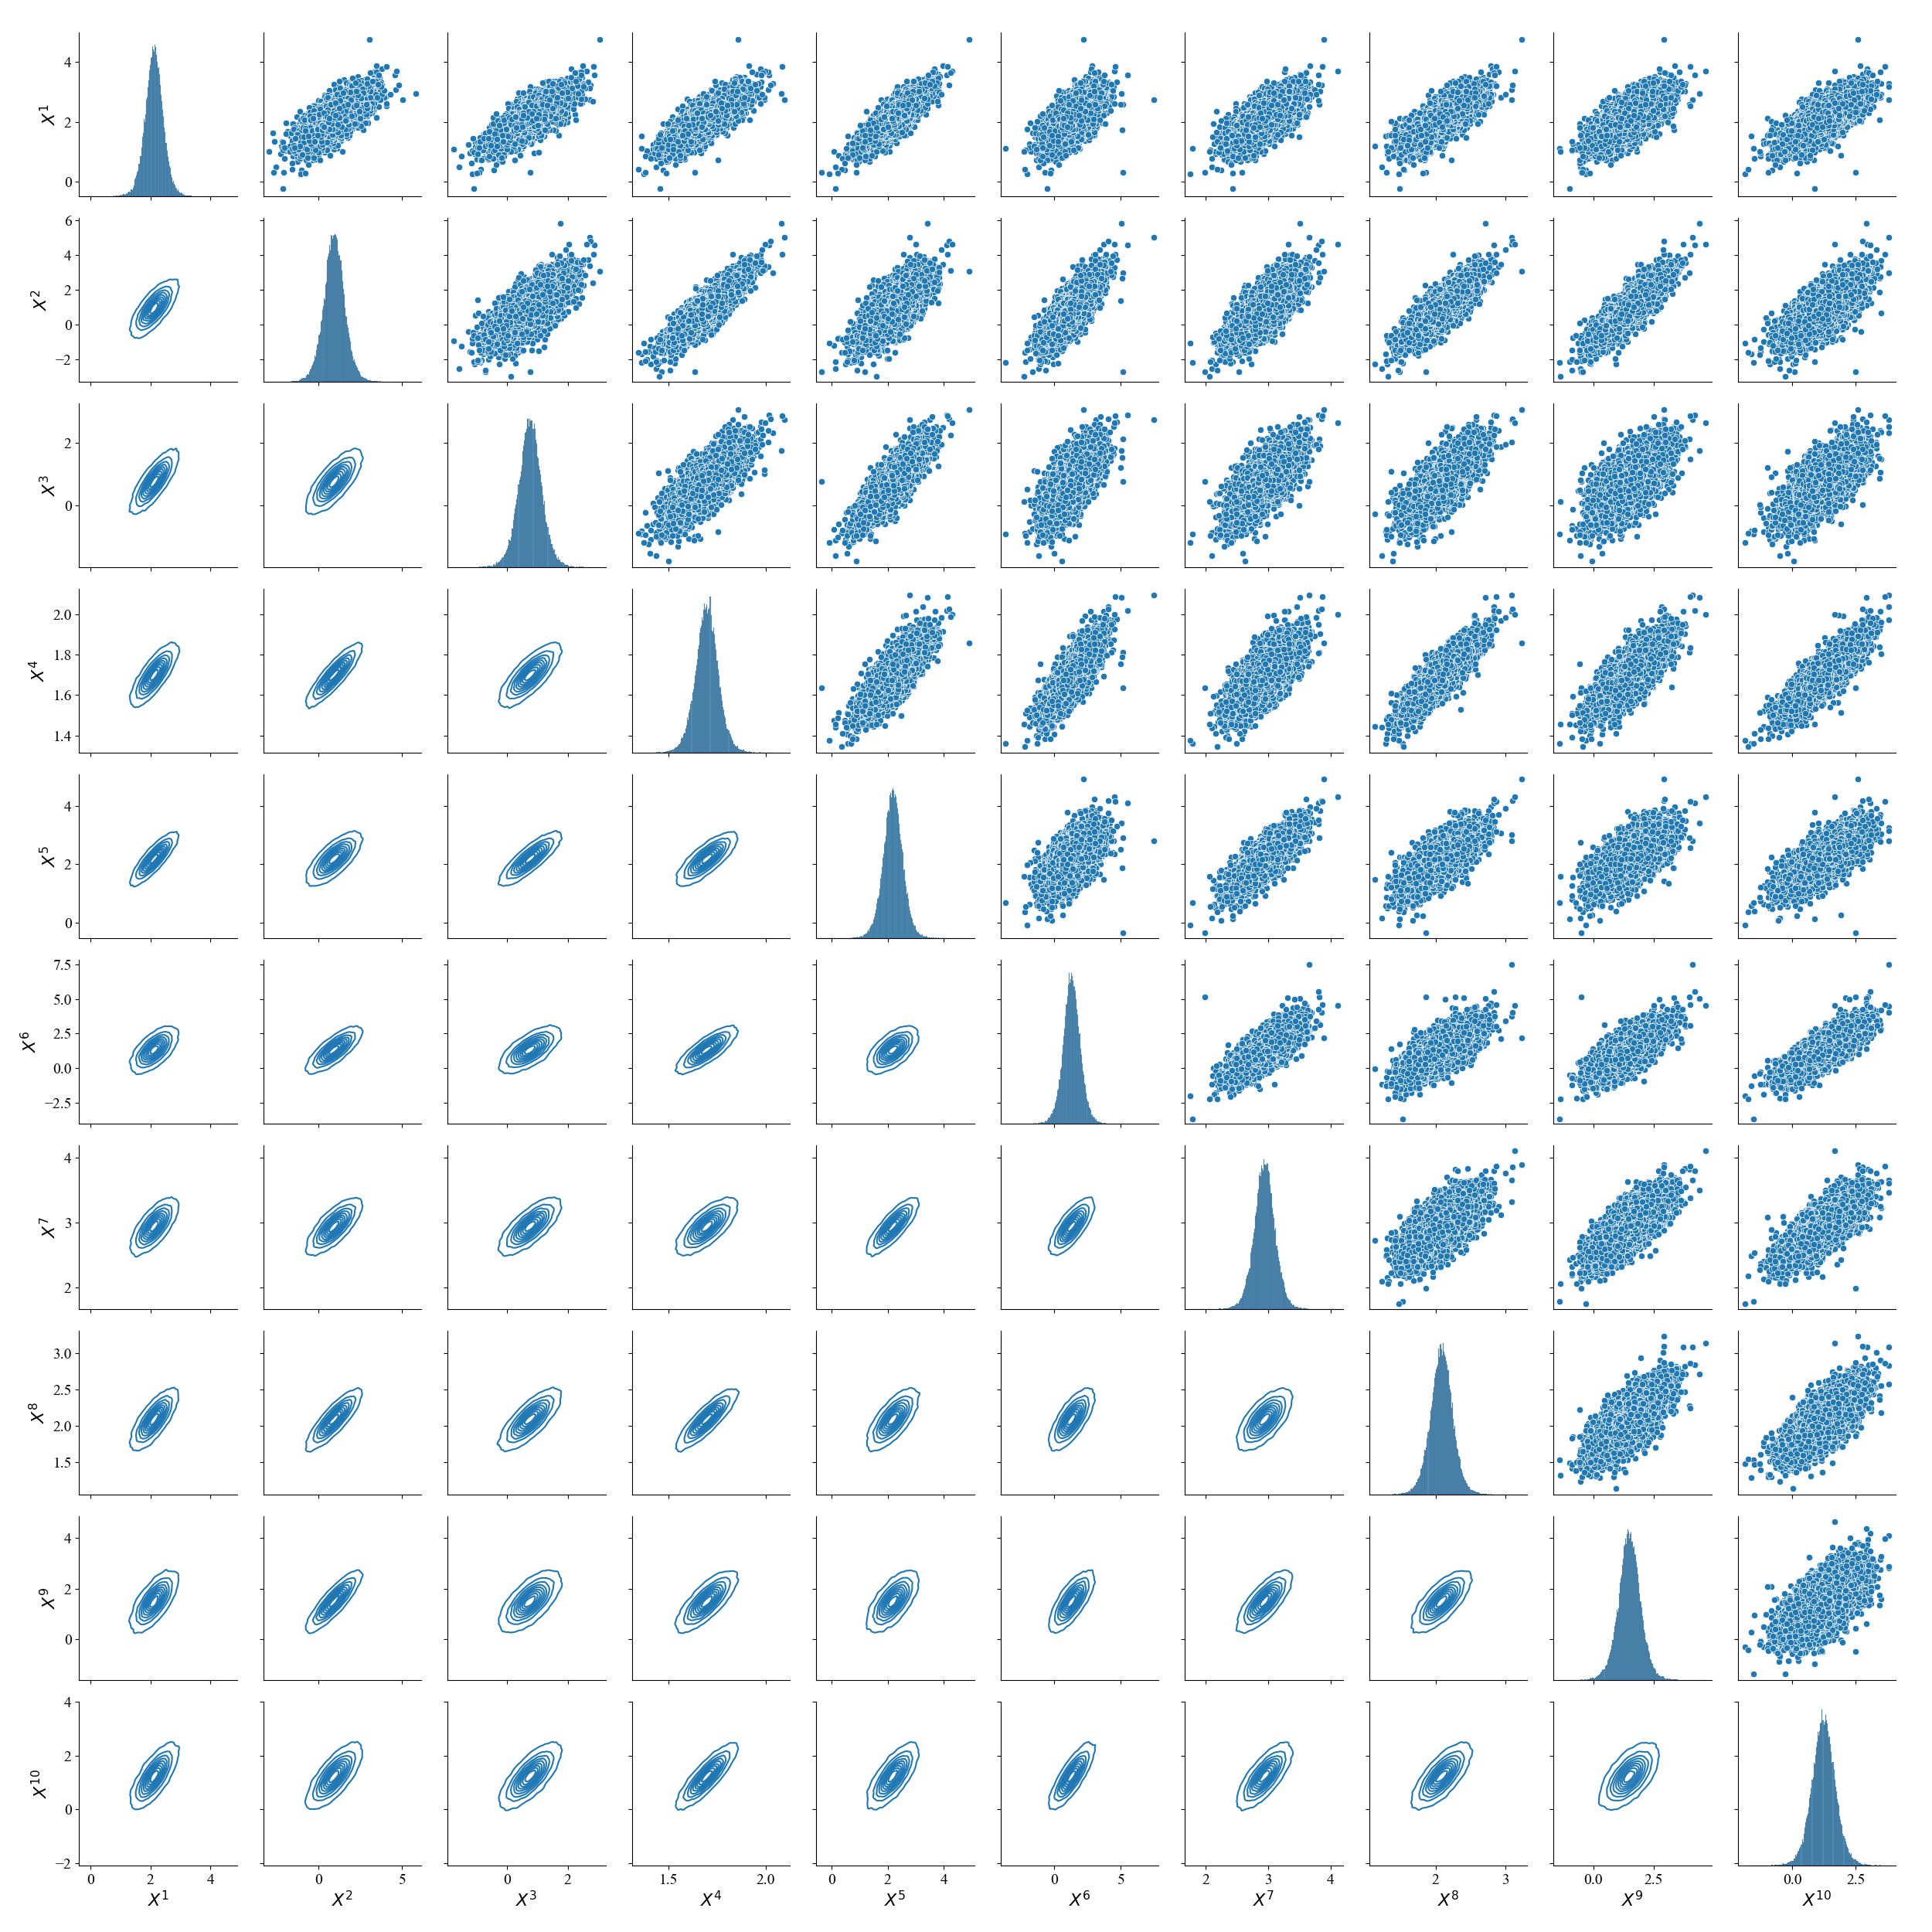

In [10]:
if regen_plots:
    plt.figure(figsize=(15, 10)) 
    g=sns.PairGrid(pd.DataFrame(X_t_train.numpy()))
    g.map_upper(sns.scatterplot)
    g.map_lower(sns.kdeplot)
    g.map_diag(sns.histplot)

    for i, ax in enumerate(g.axes.flatten()):
        ax.set_xlabel(f'$X^{{{i%10 + 1}}}$', fontsize=16)
        if i % (N + 1) == 0:
            ax.set_xlabel(f'$X^{{{i // (N + 1) + 1}}}$', fontsize=16)
            ax.set_ylabel(f'$X^{{{i // (N + 1) + 1}}}$', fontsize=16)
        elif (i-1) % (N + 1) < N:
            num = int((i-1 % (N + 1) + 1)/10 + 1)
            ax.set_ylabel(f'$X^{{{num}}}$', fontsize=16)

    plt.savefig('fig/X_t_train.png')
    plt.show()
else:
    display(Image(filename='fig/X_t_train.png'))

## Copula distributed risk factors

Jointly copula-distributed risk factors can be simulated using the following decomposition:
$$\mathbf{U}=\Phi(\mathbf{X})$$
where $\mathbf{X}=A\mathbf{Z}$ with $\mathbf{Z} \sim N(0,P)$ with $P$ being the correlation matrix. $A$ is the lower triangular matrix obtained from the Cholesky decomposition, $P=AA'$ (Mcneil et al., 2015).

In [11]:
def generate_copula(shape=[1, 1], mean=0, cor=0.5):
    num_samples = shape[0]
    N = shape[1]
    std = np.diag(cor).tolist()

    mean = tf.constant(mean, dtype=tf.float32)
    cor = tf.constant(cor, dtype=tf.float32)
    std = tf.constant(std, dtype=tf.float32)
    
    A = tf.linalg.cholesky(cor)
    Z = tf.random.normal(shape=(num_samples, N))
    X = tf.matmul(Z, tf.transpose(A))

    U = tfp.distributions.Normal(mean, std).cdf(X)
    
    return U

In [12]:
X_cop_train = generate_copula([num_samples,N], np.repeat(0, N), correlation_matrix)
np.save('sim_data/X_cop_train.npy', X_cop_train)
X_cop_test = generate_copula([num_samples,N], np.repeat(0, N), correlation_matrix)
np.save('sim_data/X_cop_test.npy', X_cop_test)

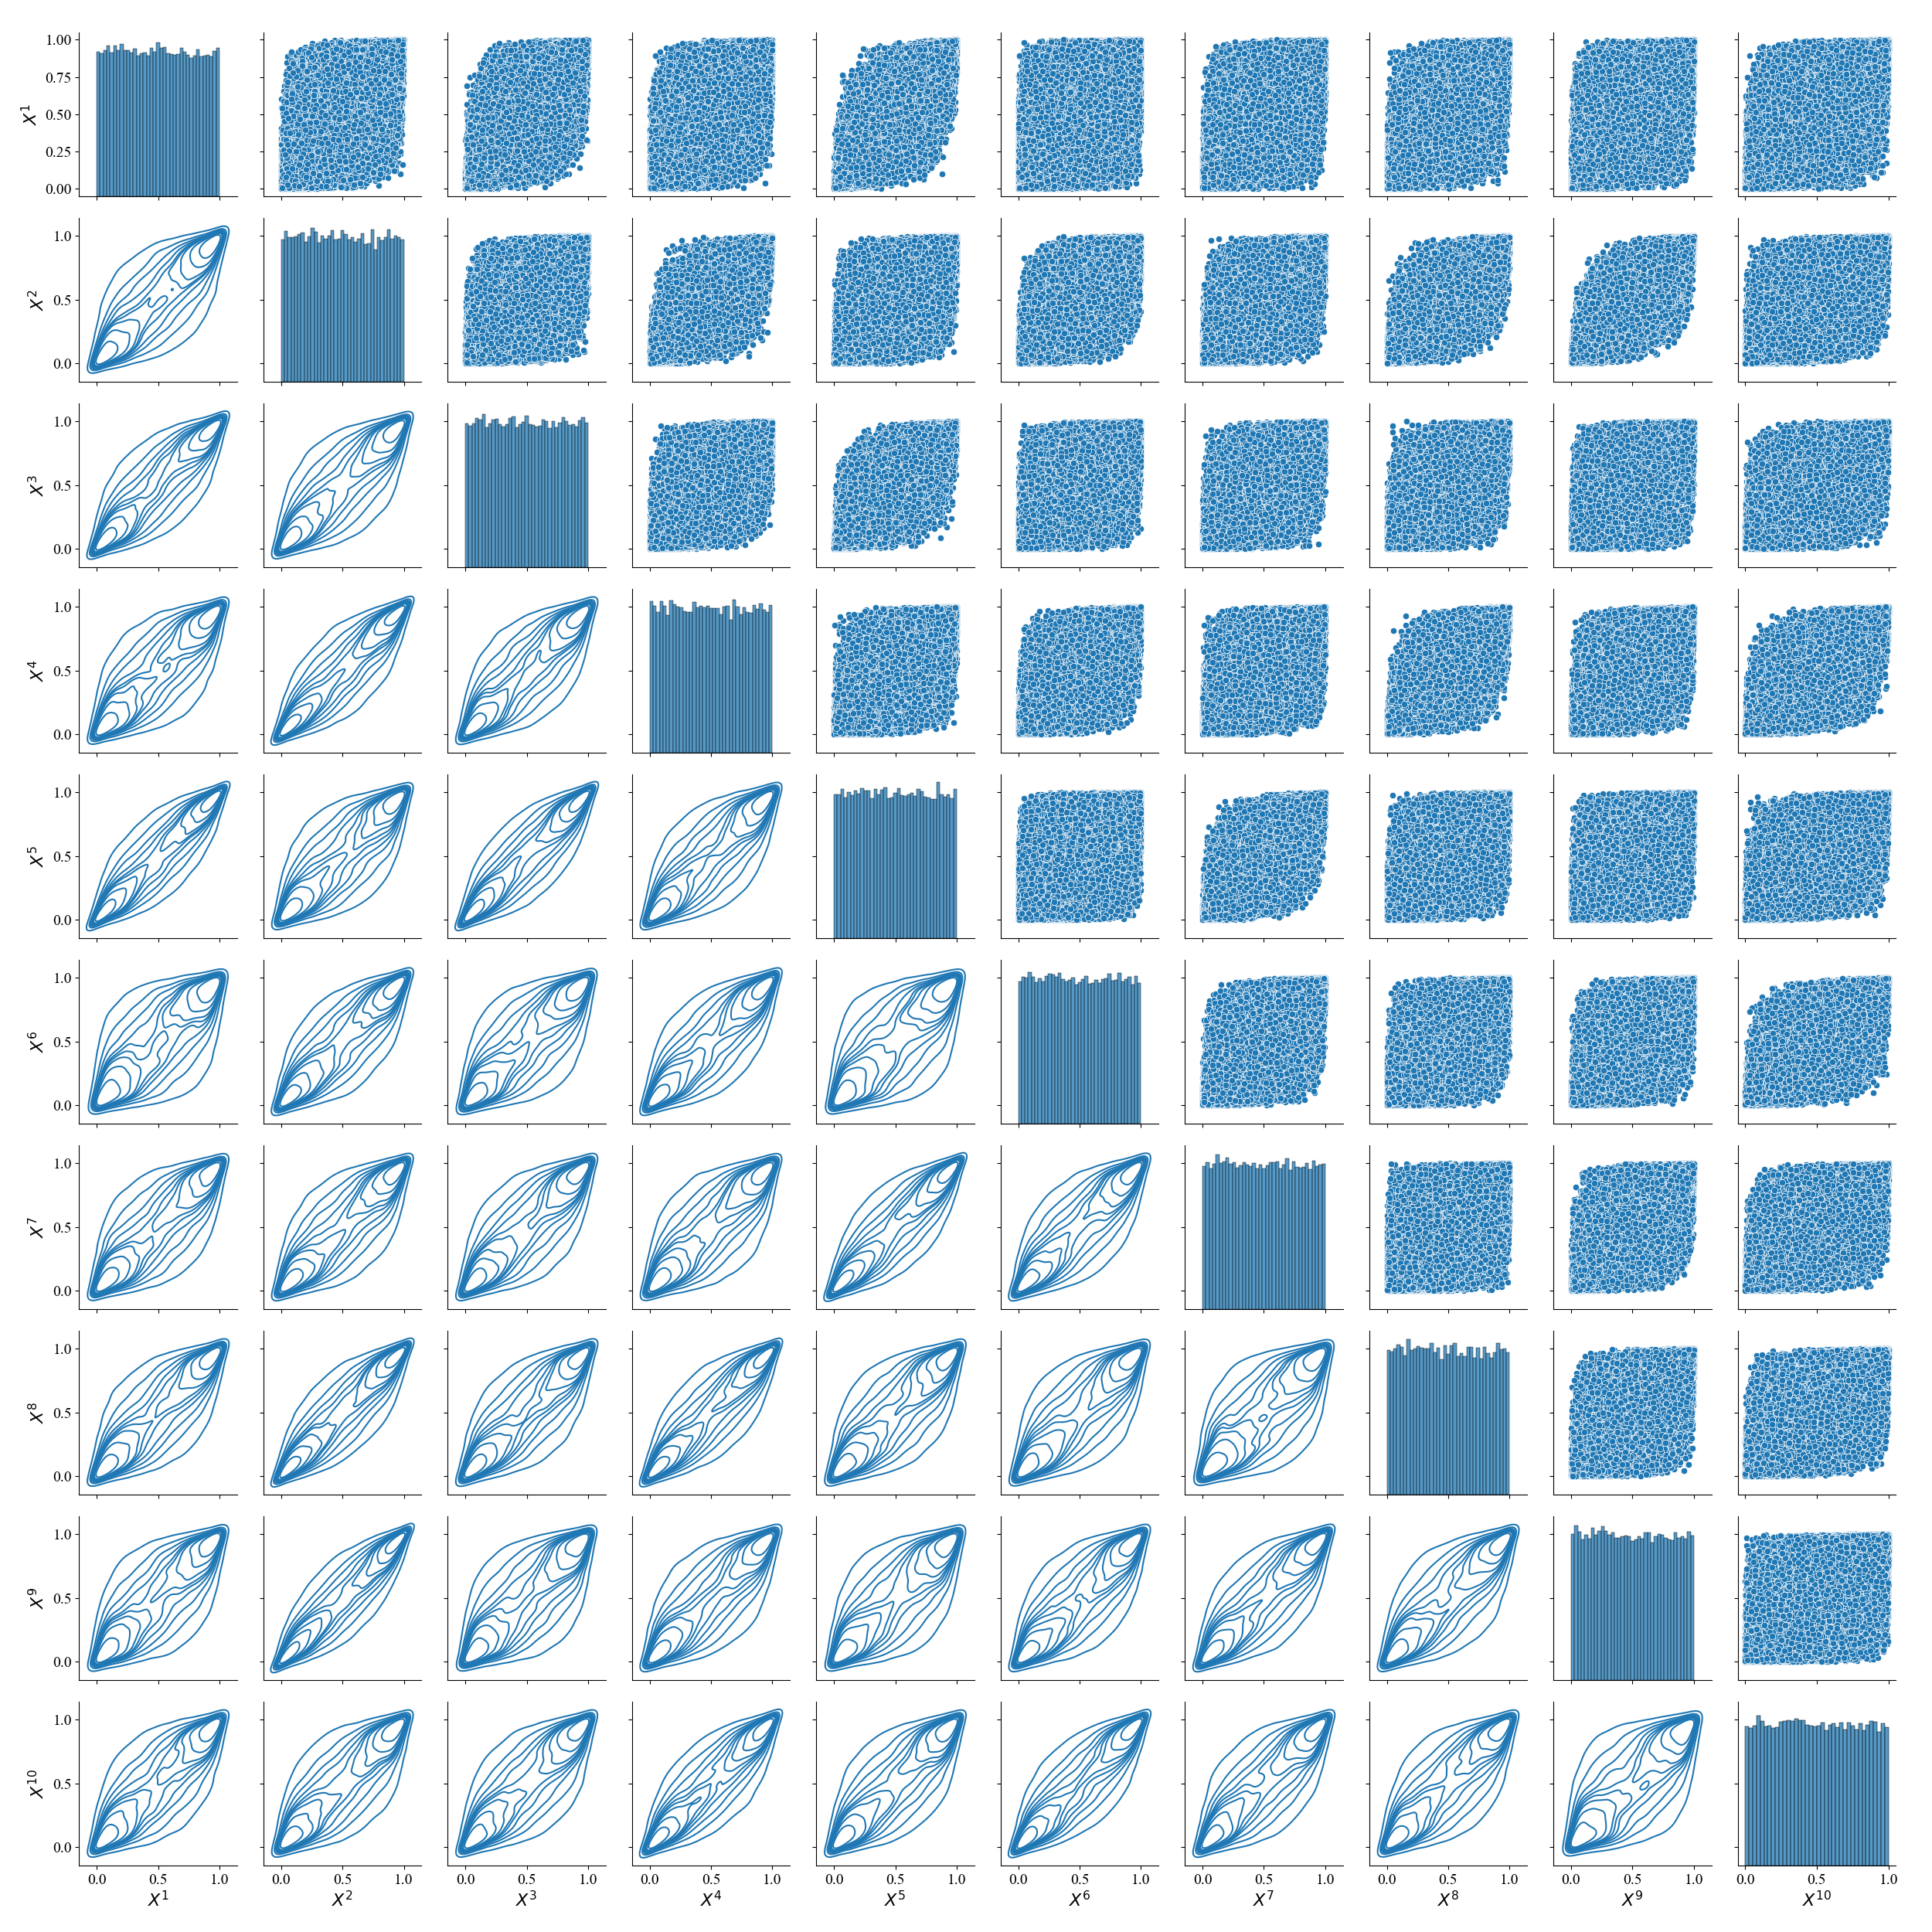

In [13]:
if regen_plots:
    plt.figure(figsize=(15, 10)) 
    g=sns.PairGrid(pd.DataFrame(X_cop_train.numpy()))
    g.map_upper(sns.scatterplot)
    g.map_lower(sns.kdeplot)
    g.map_diag(sns.histplot)

    for i, ax in enumerate(g.axes.flatten()):
        ax.set_xlabel(f'$X^{{{i%10 + 1}}}$', fontsize=16)
        if i % (N + 1) == 0:
            # Diagonal labels
            ax.set_xlabel(f'$X^{{{i // (N + 1) + 1}}}$', fontsize=16)
            ax.set_ylabel(f'$X^{{{i // (N + 1) + 1}}}$', fontsize=16)
        elif (i-1) % (N + 1) < N:
            # Left column labels
            num = int((i-1 % (N + 1) + 1)/10 + 1)
            ax.set_ylabel(f'$X^{{{num}}}$', fontsize=16)

    plt.savefig('fig/X_cop_train.png')
    plt.show()
else:
    display(Image(filename='fig/X_cop_train.png'))

## Comparison of normal and Student-t distributed risk factors

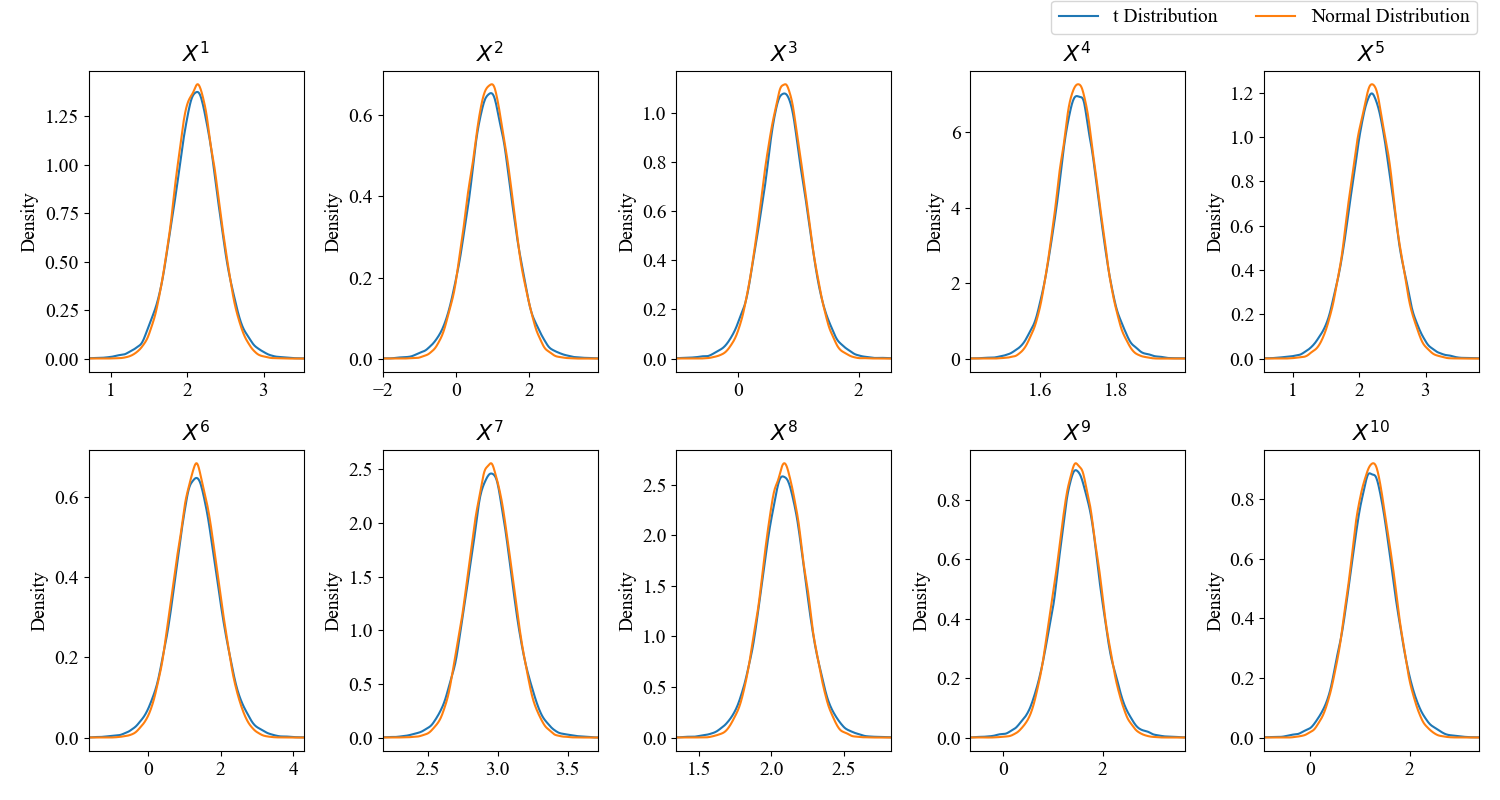

In [14]:
if regen_plots:
    plt.figure(figsize=(15, 8)) 
    for i in range(N):
        plt.subplot(2, 5, i+1)
        pd.DataFrame(X_t_train)[i].plot(kind='density', label='t Distribution')
        pd.DataFrame(X_norm_train)[i].plot(kind='density', label='Normal Distribution')
        plt.xlim(mean_X[i] - 5*std_devs[i], mean_X[i] + 5*std_devs[i])
        plt.title(r'$X^{{{}}}$'.format(i+1), fontsize=16)

    plt.suptitle('', fontsize=16)
    plt.tight_layout()
    plt.legend(loc='upper center', bbox_to_anchor=(0, 2.52), ncol=2)
    plt.savefig('fig/X_train_dist.png')
    plt.show()
else:
    display(Image(filename='fig/X_train_dist.png'))

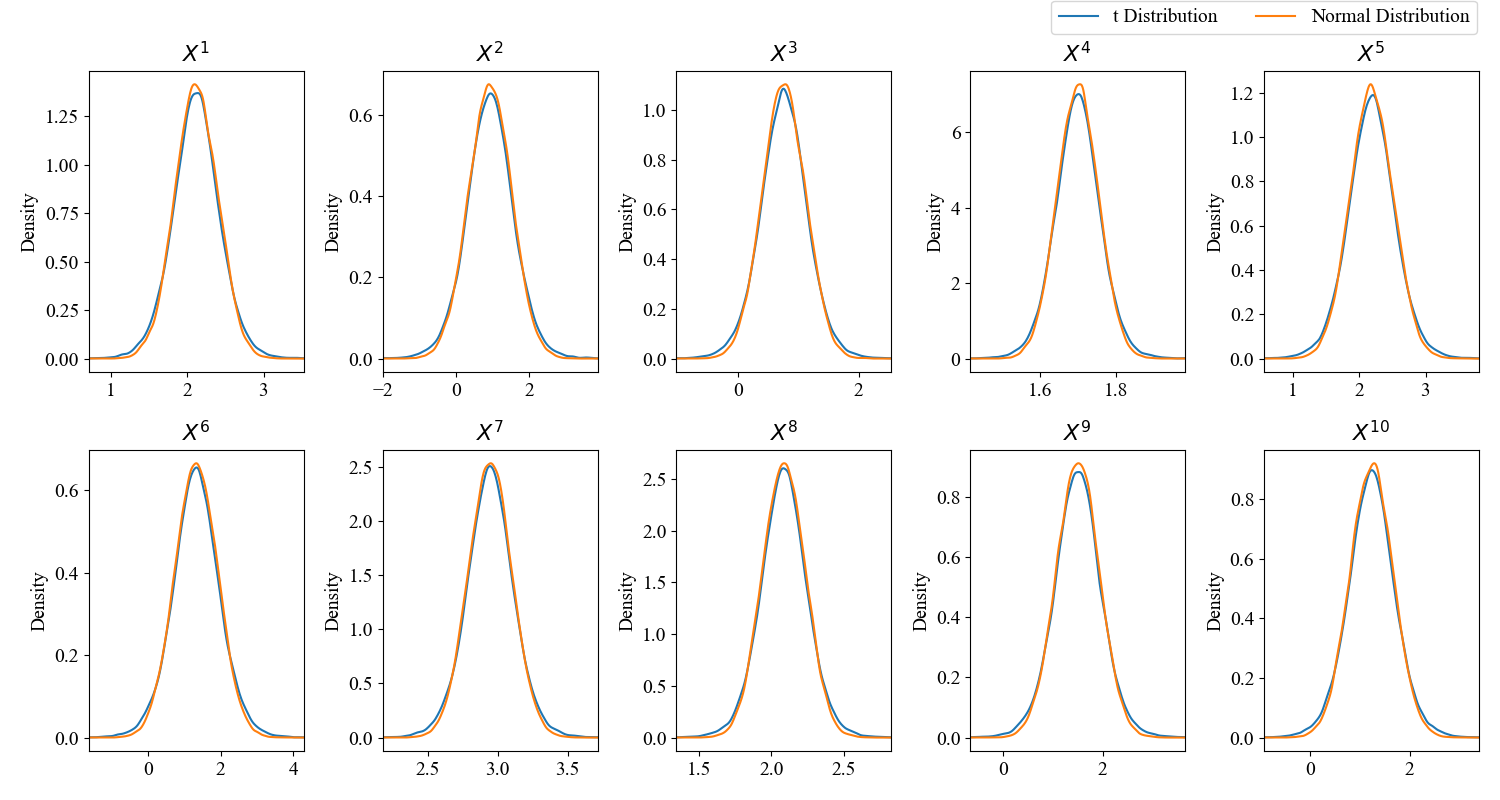

In [15]:
if regen_plots:
    plt.figure(figsize=(15, 8)) 
    for i in range(N):
        plt.subplot(2, 5, i+1)
        pd.DataFrame(X_t_test)[i].plot(kind='density', label='t Distribution')
        pd.DataFrame(X_norm_test)[i].plot(kind='density', label='Normal Distribution')
        plt.xlim(mean_X[i] - 5*std_devs[i], mean_X[i] + 5*std_devs[i])
        plt.title(r'$X^{{{}}}$'.format(i+1), fontsize=16)

    plt.suptitle('', fontsize=16)
    plt.tight_layout()
    plt.legend(loc='upper center', bbox_to_anchor=(0, 2.52), ncol=2)
    plt.savefig('fig/X_test_dist.png')
    plt.show()
else:
    display(Image(filename='fig/X_test_dist.png'))

## References

Genz, A., & Bretz, F. (2009). Computation of multivariate normal and t probabilities (1st ed.). Springer Berlin, Heidelberg.

Hurd, T. R. (2016). Systemic risk basics (pp. 1–17). Contagion! Systemic Risk in Financial Networks; Springer International Publishing.

Mcneil, A. J., Frey, R., & Embrechts, P. (2015). Quantitative risk management : Concepts, techniques and tools. Princeton University Press.